<a href="https://colab.research.google.com/github/aznedac2/CS231N_17_KOR_SUB/blob/master/vol_coin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip uninstall -y eth-abi
!pip install eth-abi==2.2.0

### 각각의 이더리움 블록에는 아래처럼 기록 남아있음

Block #23036803  
  ─ Transaction 1  
    └─ Calls Uniswap contract  
       └─ Emits Swap event → stored in logs  

23036803 블록에 여러 Transaction(사용자가 실행한 작업, 스왑/전송/예치 등) 있는데, 이는 마치 우편가방의 편지 1개와도 같음  
Log는 해당 편지에 포함된 영수증같은거임  
Transaction 1 해석해보면, 수신자가 Uniswap contract이고, call 당한 uniswap은 swap event를 emit(발생)시킴. emit한 이벤트 정보는 log에 stored 됨

In [4]:
from eth_abi import decode_abi
from web3 import Web3
import requests
from collections import defaultdict

api_key = '3833929ab39f4bcfb16a5ff5f724d938'
INFURA_URL = "https://mainnet.infura.io/v3/" + api_key

w3 = Web3(Web3.HTTPProvider(INFURA_URL))

# 2. 블록 범위 설정 (유니스왑은 이더리움 블록체인 위에 있는 스마트 컨트랙트[일종의 프로그램]이므로 w3.etf로 block 확인)
END_BLOCK = w3.eth.block_number
START_BLOCK = END_BLOCK - 100  # 최근 1000 블록 기준

# 3. Uniswap V3 Swap 이벤트 시그니처 (블록 안에서 유니스왑의 swap 이벤트 찾기위한 시그니처)
SWAP_EVENT_SIGNATURE = "0x" + w3.keccak(
    text="Swap(address,address,int256,int256,uint160,uint128,int24)"
).hex()

In [5]:
# 4. Swap 로그 수집 함수
def get_swap_logs(start_block, end_block, step=100):
    all_logs = []

    for block_start in range(start_block, end_block, step):
        block_end = min(block_start + step - 1, end_block)
        print(f"📦 Fetching logs from block {block_start} to {block_end}...")

        try:
            logs = w3.eth.get_logs({
                "fromBlock": block_start,
                "toBlock": block_end,
                "topics": [SWAP_EVENT_SIGNATURE]
            })
            all_logs.extend(logs)
        except Exception as e:
            print(f"⚠️ Error from block {block_start} to {block_end}: {e}")

    print(f"✅ Total logs fetched: {len(all_logs)}")
    return all_logs

In [6]:
# address : 해당 이벤트 발생시킨 스마트컨트랙트 주소 (ex. Uniswap v3의 BTC/USDT 풀)
# topics : SWAP_EVENT_SIGNATURE / sender 주소 / recipient 주소

logs = get_swap_logs(START_BLOCK, END_BLOCK)
logs[0]

📦 Fetching logs from block 23037862 to 23037961...
✅ Total logs fetched: 988


AttributeDict({'removed': False,
 'logIndex': 107,
 'transactionIndex': 12,
 'transactionHash': HexBytes('0x05193bcd5a22b696067169a93f8bca6e0cccea3e3ea44213b50da18a4a44b92e'),
 'blockHash': HexBytes('0xbcc56d5a86f94963164007d74b39e20567da20130b71a6f2d7d4542aa4971c80'),
 'blockNumber': 23037862,
 'address': '0xBd233D685eDE81E00faaEFEbD55150C76778a34e',
 'data': HexBytes('0xffffffffffffffffffffffffffffffffffffffffffffffffff9926cb1b1f4a170000000000000000000000000000000000000000000000926be7a57d1a14000000000000000000000000000000000000000001308d3adf08a646b2b8b35268f200000000000000000000000000000000000000000000007316d17d8ea1a886ad000000000000000000000000000000000000000000000000000000000001bece'),
 'topics': [HexBytes('0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67'),
  HexBytes('0x00000000000000000000000066a9893cc07d91d95644aedd05d03f95e1dba8af'),
  HexBytes('0x00000000000000000000000066a9893cc07d91d95644aedd05d03f95e1dba8af')]})

In [1]:
!pip install --upgrade --force-reinstall eth-abi

  Using cached eth_abi-5.2.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached eth_utils-5.3.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached eth_typing-5.2.1-py3-none-any.whl.metadata (3.2 kB)
  Using cached parsimonious-0.10.0-py3-none-any.whl.metadata (25 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached eth_hash-0.7.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached cytoolz-1.0.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.6 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached regex-2025.7.34-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (40 kB)
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.33.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached typing_inspection-0.4.1-py3-none-

In [2]:
from eth_abi import decode_abi

ImportError: cannot import name 'decode_abi' from 'eth_abi' (/usr/local/lib/python3.11/dist-packages/eth_abi/__init__.py)

In [ ]:
eth_abi.decode

In [4]:
import eth_abi

# 예시: uint256 하나 디코딩 (값: 1000)
raw_data = bytes.fromhex("00000000000000000000000000000000000000000000000000000000000003e8")
decoded = eth_abi.decode_abi(['uint256'], raw_data)
print(decoded)  # [1000]

AttributeError: module 'eth_abi' has no attribute 'decode_abi'

In [14]:
# 5. 로그를 풀별로 정리
def analyze_logs(logs):
    pool_stats = defaultdict(lambda: {"tx_count": 0, "volume_usd": 0})

    for log in logs:
      pool = log['address']
      pool_stats[pool]["tx_count"] += 1
      pool_stats[pool]["volume_usd"] += 1000  # 임시: tx 당 평균 1000 USD 가정
      print(pool_stats)

    return pool_stats

In [20]:
pool_data = analyze_logs(logs)

defaultdict(<function __main__.analyze_logs.<locals>.<lambda>()>,
            {'0xBd233D685eDE81E00faaEFEbD55150C76778a34e': {'tx_count': 1,
              'volume_usd': 1000},
             '0xF12533a96712133d9Bb97C24de5BCf52F48851BD': {'tx_count': 35,
              'volume_usd': 35000},
             '0xfa06982d442DEAc6ce57dedce29D55CC6ff99D73': {'tx_count': 1,
              'volume_usd': 1000},
             '0xef530078320f3A9223661e2Fe37001023048a7dF': {'tx_count': 3,
              'volume_usd': 3000},
             '0x1910E073709Ee97ed0898273C4D58338a2A4AE94': {'tx_count': 2,
              'volume_usd': 2000},
             '0xa6Cc3C2531FdaA6Ae1A3CA84c2855806728693e8': {'tx_count': 3,
              'volume_usd': 3000},
             '0xc72AbB13B6BDfA64770cb5B1F57Bebd36a91A29E': {'tx_count': 1,
              'volume_usd': 1000},
             '0x76665642F513aAf2A00bE05711A598F44e3970A7': {'tx_count': 5,
              'volume_usd': 5000},
             '0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f

In [11]:
pool_data

defaultdict(<function __main__.analyze_logs.<locals>.<lambda>()>,
            {'0xBd233D685eDE81E00faaEFEbD55150C76778a34e': {'tx_count': 1,
              'volume_usd': 1000},
             '0xF12533a96712133d9Bb97C24de5BCf52F48851BD': {'tx_count': 35,
              'volume_usd': 35000},
             '0xfa06982d442DEAc6ce57dedce29D55CC6ff99D73': {'tx_count': 1,
              'volume_usd': 1000},
             '0xef530078320f3A9223661e2Fe37001023048a7dF': {'tx_count': 3,
              'volume_usd': 3000},
             '0x1910E073709Ee97ed0898273C4D58338a2A4AE94': {'tx_count': 2,
              'volume_usd': 2000},
             '0xa6Cc3C2531FdaA6Ae1A3CA84c2855806728693e8': {'tx_count': 3,
              'volume_usd': 3000},
             '0xc72AbB13B6BDfA64770cb5B1F57Bebd36a91A29E': {'tx_count': 1,
              'volume_usd': 1000},
             '0x76665642F513aAf2A00bE05711A598F44e3970A7': {'tx_count': 5,
              'volume_usd': 5000},
             '0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f

In [16]:
# 5. 로그를 풀별로 정리
def analyze_logs(logs):
    pool_stats = defaultdict(lambda: {"tx_count": 0, "volume_usd": 0})

    for log in logs:
        pool = log['address']
        pool_stats[pool]["tx_count"] += 1
        pool_stats[pool]["volume_usd"] += 1000  # 임시: tx 당 평균 1000 USD 가정

    return pool_stats

# 6. DefiLlama에서 TVL (유동성) 데이터 가져오기
def get_tvl_data():
    url = "https://api.llama.fi/protocol/uniswap"
    res = requests.get(url)
    data = res.json()
    tvl = data["tvl"][-1]["totalLiquidityUSD"]
    return tvl

# 7. 예상 APY 계산
def calculate_apy(volume, liquidity, fee_rate=0.003):
    daily_fee = volume * fee_rate
    apy = (daily_fee * 365) / liquidity * 100
    return round(apy, 2)

In [ ]:
print(f"🔍 최근 {END_BLOCK - START_BLOCK} 블록 내 거래 분석 결과:\n")
for pool, stats in pool_data.items():
    liquidity = 1_000_000  # 임시: 모든 풀의 TVL을 100만 달러로 가정
    apy = calculate_apy(stats["volume_usd"], liquidity)
    print(f"풀 주소: {pool} | 거래수: {stats['tx_count']} | 볼륨: ${stats['volume_usd']} | 예상 APY: {apy}%")

In [ ]:
!pip install yfinance arch statsmodels seaborn aiohttp pysabr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 25.9 MB/s eta 0:00:00


In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time

def fetch_deribit_candles(instrument_name='BTC-PERPETUAL', resolution='1', start_timestamp=None, end_timestamp=None):
    """
    Deribit API에서 캔들 데이터 가져오기
    resolution: '1' for 1-minute, '5' for 5-minute, etc.
    """
    url = "https://www.deribit.com/api/v2/public/get_tradingview_chart_data"

    params = {
        "instrument_name": instrument_name,
        "resolution": resolution,
        "start_timestamp": start_timestamp,
        "end_timestamp": end_timestamp,
    }

    resp = requests.get(url, params=params)
    data = resp.json()

    if 'result' not in data:
        print("Error:", data)
        return None

    df = pd.DataFrame(data['result'])
    df['timestamp'] = pd.to_datetime(df['ticks'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']]
    return df

def get_daily_ohlc(start_date, end_date):
    """
    지정된 기간 동안 일별 OHLC 데이터 리턴
    """
    all_data = []
    current_date = start_date
    while current_date <= end_date:
        start_ts = int(current_date.timestamp() * 1000)
        end_ts = int((current_date + timedelta(days=1)).timestamp() * 1000)

        print(f"Fetching data for: {current_date.date()}")
        df = fetch_deribit_candles(start_timestamp=start_ts, end_timestamp=end_ts)

        if df is not None and not df.empty:
            # 일별 OHLC로 리샘플링
            daily = df.resample('1D').agg({
                'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last',
                'volume': 'sum'
            })
            all_data.append(daily)

        time.sleep(0.3)  # API 요청 제한 회피
        current_date += timedelta(days=1)

    final_df = pd.concat(all_data)
    return final_df

In [ ]:
# 사용 예시
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 4, 5)
df_daily = get_daily_ohlc(start_date, end_date)
print(df_daily)

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import skew, kurtosis, normaltest

# 1. 데이터 수집 (BTCUSDT)
btc = yf.download("BTC-USD", start="2015-01-01", end="2025-04-01")
btc.columns = btc.columns.levels[0]
btc["log_ret"] = np.log(btc["Close"] / btc["Close"].shift(1))
returns = btc["log_ret"].dropna()


[*********************100%***********************]  1 of 1 completed


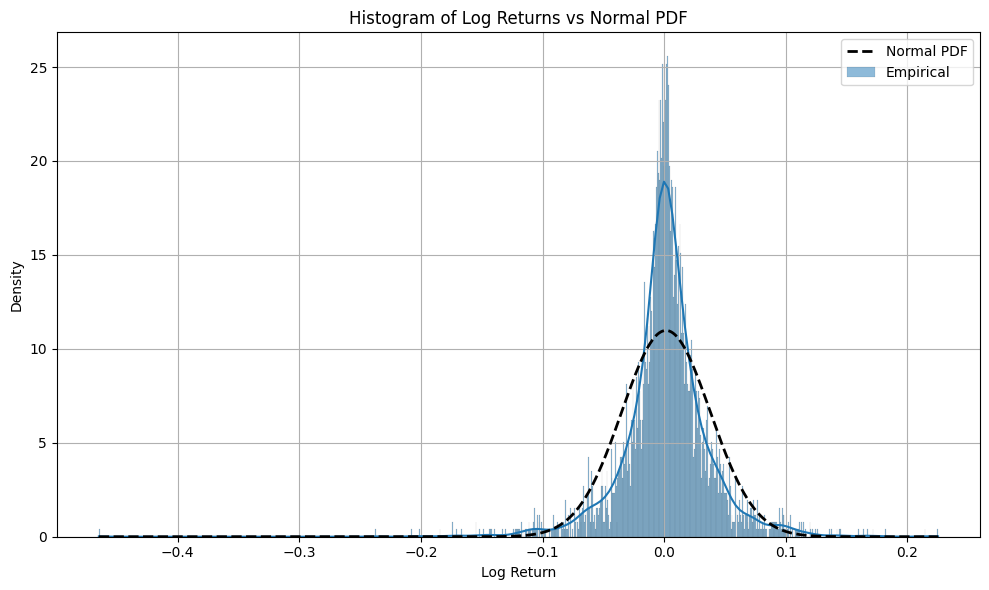

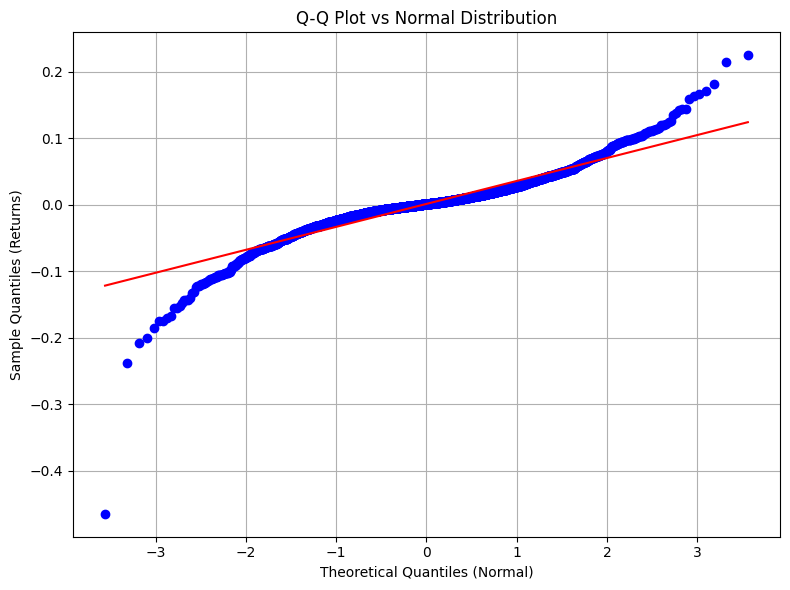

Normality Test p-value: 0.0000
p-value가 0.05 이하면 정규분포로 보기 어려우므로 constant vol 모델 사용 어려움


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from scipy.stats import norm

# 히스토그램 + 정규분포 PDF 비교 시각화
plt.figure(figsize=(10, 6))
sns.histplot(returns, bins=1000, kde=True, stat="density", label="Empirical")

# 정규분포 PDF 계산
x = np.linspace(returns.min(), returns.max(), 1000)
pdf = norm.pdf(x, returns.mean(), returns.std())
plt.plot(x, pdf, color='black', linestyle='--', linewidth=2, label="Normal PDF")

# 그래프 설정
# plt.xlim(-0.2, -0.1)
plt.title("Histogram of Log Returns vs Normal PDF")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Q-Q 플롯 (정규분포와 비교)
plt.figure(figsize=(8, 6))
probplot(returns, dist="norm", plot=plt)
plt.title("Q-Q Plot vs Normal Distribution")
plt.xlabel("Theoretical Quantiles (Normal)")
plt.ylabel("Sample Quantiles (Returns)")
plt.grid(True)
plt.tight_layout()
plt.show()


# 2. 분포 분석
stat, p = normaltest(returns)
print(f"Normality Test p-value: {p:.4f}")
print('p-value가 0.05 이하면 정규분포로 보기 어려우므로 constant vol 모델 사용 어려움')


In [ ]:
print(f"Skewness: {skew(returns):.3f}")
print(f"Kurtosis: {kurtosis(returns, fisher=True):.3f}")

print('Skewness가 0에서 벗어나있으므로 왜도 있고, Kurtosis가 3 이상이라 Fat-tail로 볼 수 있음')

Skewness: -0.744
Kurtosis: 11.557
Skewness가 0에서 벗어나있으므로 왜도 있고, Kurtosis가 3 이상이라 Fat-tail로 볼 수 있음


In [ ]:
# 3. ARCH 효과 테스트
arch_stat, arch_pvalue, _, _ = het_arch(returns)
print(f"ARCH test p-value: {arch_pvalue:.4f}")

# 4. GARCH(1,1) 적합
model = arch_model(returns, vol='Garch', p=1, q=1)
res = model.fit(disp="off")
print(res.summary())


ARCH test p-value: 0.0000
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2582.65
Distribution:                  Normal   AIC:                          -5157.30
Method:            Maximum Likelihood   BIC:                          -5136.99
                                        No. Observations:                 1185
Date:                Mon, Apr 21 2025   Df Residuals:                     1184
Time:                        04:22:47   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1810e-03  7.340e

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


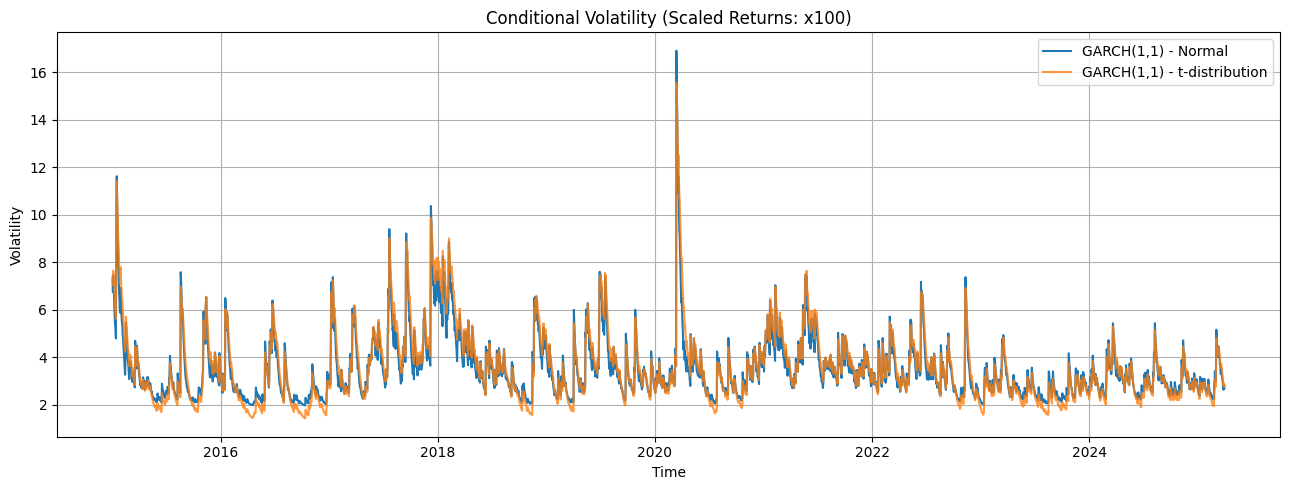

AIC (Normal): 19610.99
AIC (t-dist): 18645.75
Estimated nu (t-dist degrees of freedom): 3.16


In [ ]:
# 📌 GARCH 최적화 안정성을 위해 스케일 조정
returns_scaled = returns * 100

# GARCH(1,1) - Normal
model_normal = arch_model(returns_scaled, vol='GARCH', p=1, q=1, dist='normal')
res_normal = model_normal.fit(disp='off')

# GARCH(1,1) - t-distribution
model_t = arch_model(returns_scaled, vol='GARCH', p=1, q=1, dist='t')
res_t = model_t.fit(disp='off')

# 조건부 변동성
vol_normal = res_normal.conditional_volatility
vol_t = res_t.conditional_volatility

# 시각화
plt.figure(figsize=(13, 5))
plt.plot(vol_normal, label='GARCH(1,1) - Normal')
plt.plot(vol_t, label='GARCH(1,1) - t-distribution', alpha=0.8)
plt.title("Conditional Volatility (Scaled Returns: x100)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 성능 지표 출력
print(f"AIC (Normal): {res_normal.aic:.2f}")
print(f"AIC (t-dist): {res_t.aic:.2f}")
print(f"Estimated nu (t-dist degrees of freedom): {res_t.params['nu']:.2f}")

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Skewness: 0.0867
Kurtosis: 22.2356
Normality test p-value: 0.0000


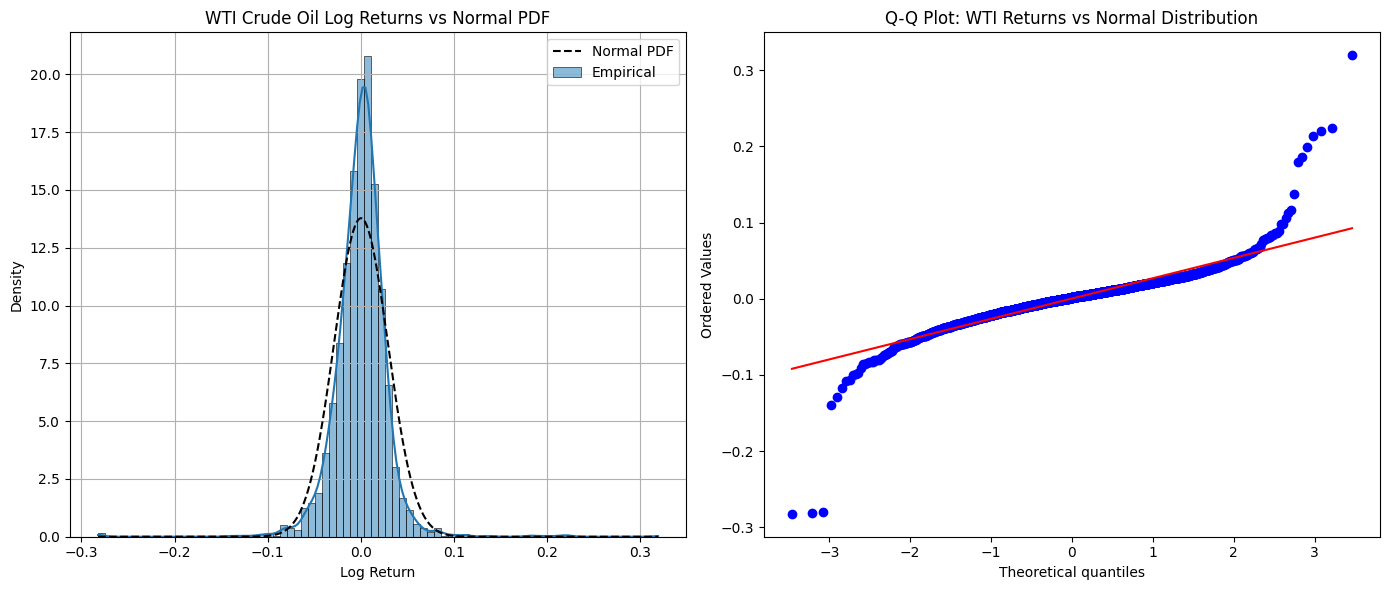

In [ ]:
# 1. WTI 원유 선물 데이터 다운로드 (CL=F)
wti = yf.download("CL=F", start="2015-01-01", end="2025-04-01")
wti.columns = wti.columns.levels[0]
wti["log_ret"] = np.log(wti["Close"] / wti["Close"].shift(1))
returns = wti["log_ret"].dropna()

# 2. 통계량 계산
print(f"Skewness: {skew(returns):.4f}")
print(f"Kurtosis: {kurtosis(returns, fisher=True):.4f}")
print(f"Normality test p-value: {normaltest(returns).pvalue:.4f}")

# 3. 시각화: 히스토그램 + 정규분포 PDF
plt.figure(figsize=(14, 6))

# 히스토그램 + 정규 PDF
plt.subplot(1, 2, 1)
sns.histplot(returns, bins=80, kde=True, stat="density", label="Empirical")
x = np.linspace(returns.min(), returns.max(), 1000)
pdf = norm.pdf(x, returns.mean(), returns.std())
plt.plot(x, pdf, 'k--', label='Normal PDF')
plt.title("WTI Crude Oil Log Returns vs Normal PDF")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Q-Q 플롯
plt.subplot(1, 2, 2)
probplot(returns, dist="norm", plot=plt)
plt.title("Q-Q Plot: WTI Returns vs Normal Distribution")

plt.tight_layout()
plt.show()


In [ ]:
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import norm
from scipy.optimize import brentq

from datetime import datetime

# Black-Scholes 가격 계산 함수
def bs_price(option_type, S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    if option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Implied Volatility 계산 함수
def implied_vol(price, option_type, S, K, T, r):
    try:
        return brentq(lambda sigma: bs_price(option_type, S, K, T, r, sigma) - price * S, 1e-5, 5)
    except:
        return np.nan

# Deribit에서 옵션 리스트 가져오기
def get_option_instruments(currency="BTC", kind="option", expired=False):
    url = "https://www.deribit.com/api/v2/public/get_instruments"
    params = {
        "currency": currency,
        "kind": kind,
        "expired": str(expired).lower()  # API는 'true' or 'false' string을 요구함
    }

    response = requests.get(url, params=params)
    data = response.json()

    if 'error' in data:
        print(f"API Error: {data['error']['message']}")
        return []

    instruments = data.get("result", [])
    return instruments

# 옵션별 IV 계산
def get_iv_for_option(inst_name, strike, expiry_timestamp, mode='mid', otm_only=True, r=0):
    url = f"https://www.deribit.com/api/v2/public/get_order_book?instrument_name={inst_name}"
    response = requests.get(url)
    data = response.json().get('result', {})

    S = data.get('underlying_price')
    K = strike
    bid = data.get('best_bid_price')
    ask = data.get('best_ask_price')
    mid = (bid + ask) / 2 if bid and ask else None

    mark_iv = data.get('mark_iv')
    bid_iv = data.get('bid_iv')
    ask_iv = data.get('ask_iv')

    if mode == 'mid':
      mid = mid
    elif mode == 'bid':
      mid = bid
    elif mode == 'ask':
      mid = ask

    T = (datetime.utcfromtimestamp(expiry_timestamp / 1000) - datetime.utcnow()).total_seconds() / (365 * 24 * 60 * 60)

    if (not mid) or (not expiry_timestamp) or (T <= 0):
        return None

    opt_type = inst_name[-1]
    # OTM : 콜옵션의 행사 가격이 기초 자산의 시장 가격보다 높을 때, 혹은 풋옵션의 행사 가격이 기초 자산의 시장 가격보다 낮을 때
    # ITM 버리기..
    if opt_type == 'C':
        opt_type = 'call'
        if otm_only is True:
            if S > K:
              return None
    elif opt_type == 'P':
        opt_type = 'put'
        if otm_only is True:
          if S < K:
            return None
    else:
        return None

    iv = implied_vol(mid, opt_type, S, K, T, r)

    expiry_date = datetime.utcfromtimestamp(expiry_timestamp / 1000).strftime('%Y-%m-%d')
    return {
        'strike': K,
        'iv': iv,
        'expiry': expiry_date,
        'mark_iv': mark_iv,
        'bid_iv': bid_iv,
        'ask_iv': ask_iv,
        'type' : opt_type
    }

# 만기별 Smile Curve 시각화
def plot_smile_curves(mode, otm_only, cutoff_str):
    options = get_option_instruments()
    iv_data = []

    cutoff_date = datetime.strptime(cutoff_str, '%Y%m%d')
    cutoff_timestamp = int(cutoff_date.timestamp() * 1000)

    for opt in options:
        inst_name = opt['instrument_name']
        strike_opt =  opt['strike']

        expiry_timestamp_opt = opt['expiration_timestamp']
        if (expiry_timestamp_opt > cutoff_timestamp):
          continue

        iv_info = get_iv_for_option(inst_name, strike_opt, expiry_timestamp_opt, mode, otm_only)

        if (iv_info and iv_info['iv'] is not None) and (iv_info['iv'] is not np.nan):
            print(inst_name, iv_info)
            # print(inst_name, iv_info['iv'])
            iv_data.append(iv_info)

    df = pd.DataFrame(iv_data)
    df = df.dropna().sort_values(['expiry', 'strike'])

    plt.figure(figsize=(12, 6))
    for expiry in sorted(df['expiry'].unique()):
        subset = df[df['expiry'] == expiry]
        plt.plot(subset['strike'], subset['iv'], marker='o', label=expiry)

    plt.title("BTC Implied Volatility Smile Curves by Expiry by " + mode)
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend(title="Expiry")
    plt.tight_layout()
    plt.show()

    df['mode'] = mode
    return df

def get_btc_futures_last_price(instrument_name="BTC-PERPETUAL"):
    """
    Deribit에서 지정한 비트코인 선물 종목의 현재가(last price)를 반환합니다.

    Parameters:
    - instrument_name: 예) 'BTC-PERPETUAL', 'BTC-27JUN25'

    Returns:
    - 현재가 (float), 실패 시 None
    """
    url = "https://www.deribit.com/api/v2/public/ticker"
    params = {"instrument_name": instrument_name}

    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data["result"]["last_price"]
    except Exception as e:
        print(f"에러 발생: {e}")
        return None

In [ ]:
# price * S // otm_only
df_ask = plot_smile_curves(mode='ask', otm_only=True, cutoff_str='20261231')
df_ask

BTC-24APR25-78000-P {'strike': 78000.0, 'iv': 2.5100109311597305, 'expiry': '2025-04-24', 'mark_iv': 103.15, 'bid_iv': 0.0, 'ask_iv': 250.98, 'type': 'put'}
BTC-24APR25-80000-P {'strike': 80000.0, 'iv': 2.191711666450438, 'expiry': '2025-04-24', 'mark_iv': 103.02, 'bid_iv': 0.0, 'ask_iv': 219.15, 'type': 'put'}
BTC-24APR25-82000-P {'strike': 82000.0, 'iv': 1.8783556232509178, 'expiry': '2025-04-24', 'mark_iv': 96.2, 'bid_iv': 0.0, 'ask_iv': 187.81, 'type': 'put'}
BTC-24APR25-83000-P {'strike': 83000.0, 'iv': 1.7224392573258216, 'expiry': '2025-04-24', 'mark_iv': 94.56, 'bid_iv': 0.0, 'ask_iv': 172.22, 'type': 'put'}
BTC-24APR25-84000-P {'strike': 84000.0, 'iv': 1.5678133980326854, 'expiry': '2025-04-24', 'mark_iv': 87.66, 'bid_iv': 0.0, 'ask_iv': 156.76, 'type': 'put'}
BTC-24APR25-85000-P {'strike': 85000.0, 'iv': 1.412873870206768, 'expiry': '2025-04-24', 'mark_iv': 82.23, 'bid_iv': 0.0, 'ask_iv': 141.27, 'type': 'put'}
BTC-24APR25-86000-P {'strike': 86000.0, 'iv': 1.2583656208363285,

KeyboardInterrupt: 

In [ ]:
# price * S // otm_only
df_bid = plot_smile_curves(mode='bid', otm_only=True, cutoff_str='20261231')
df_bid

In [ ]:
df_mid = plot_smile_curves(mode='mid', otm_only=True, cutoff_str='20261231')
df_mid

In [ ]:
df_ask_ = df_ask[['strike', 'iv', 'expiry']].rename(columns={'iv':'iv_ask'})
df_mid_ = df_mid[['strike', 'iv', 'expiry']].rename(columns={'iv':'iv_mid'})
df_bid_ = df_bid[['strike', 'iv', 'expiry']].rename(columns={'iv':'iv_bid'})

df_merged = pd.merge(df_bid_, df_ask_, on=["strike", "expiry"], how="inner")
df_merged = pd.merge(df_merged, df_mid_, on=["strike", "expiry"], how="inner")[['strike', 'expiry', 'iv_bid', 'iv_mid', 'iv_ask']]

# melt로 long form 변환|
df_long = pd.melt(df_merged, id_vars=["strike", "expiry"], value_vars=["iv_ask", "iv_mid", "iv_bid"], var_name="iv_type", value_name="implied_volatility")

# Plotly로 인터랙티브 그래프 그리기
fig = px.line(df_long, x="strike", y="implied_volatility", color="expiry", line_dash="iv_type", markers=True,
    title="Interactive Implied Volatility Curve by Expiry and IV Type",
    labels={"strike": "Strike", "implied_volatility": "Implied Volatility"})

fig.update_layout(legend_title_text="Expiry / IV Type", hovermode="x unified")
fig.show()

In [ ]:
def plot_interactive_vol_surface(df):
    df = df.copy()
    df['expiry'] = pd.to_datetime(df['expiry'])
    df['expiry_days'] = (df['expiry'] - df['expiry'].min()).dt.days

    fig = go.Figure()

    # 각 만기별로 IV Bid와 IV Ask 트레이스 추가
    for expiry in df['expiry'].unique():
        df_expiry = df[df['expiry'] == expiry]
        expiry_str = expiry.strftime('%Y-%m-%d')

        # IV Bid 트레이스
        fig.add_trace(go.Scatter3d(
            x=df_expiry['strike'],
            y=df_expiry['expiry_days'],
            z=df_expiry['iv_bid'],
            mode='markers',
            marker=dict(size=4, color='blue', line=dict(color='black', width=1)),
            name=f'IV Bid ({expiry_str})',
            legendgroup=f'IV Bid ({expiry_str})',
            showlegend=True
        ))

        # IV Ask 트레이스
        fig.add_trace(go.Scatter3d(
            x=df_expiry['strike'],
            y=df_expiry['expiry_days'],
            z=df_expiry['iv_ask'],
            mode='markers',
            marker=dict(size=4, color='red', line=dict(color='black', width=1)),
            name=f'IV Ask ({expiry_str})',
            legendgroup=f'IV Ask ({expiry_str})',
            showlegend=True
        ))

    fig.update_layout(
        title='Interactive Volatility Surface (Bid & Ask by Expiry)',
        width=1200,
        height=1200,
        scene=dict(
            xaxis_title='Strike',
            yaxis_title='Days to Expiry',
            zaxis_title='Implied Volatility'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

plot_interactive_vol_surface(df_merged)

In [ ]:
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

def plot_smooth_vol_surface(df, vol_type='iv_bid', method='cubic', sigma=1.0):
    """
    df: DataFrame with columns ['strike', 'expiry', 'iv_bid', 'iv_ask']
    vol_type: 'iv_bid' or 'iv_ask'
    method: interpolation method - 'linear', 'cubic', or 'nearest'
    sigma: standard deviation for Gaussian filter
    """
    df = df.copy()
    df['expiry'] = pd.to_datetime(df['expiry'])
    df['expiry_days'] = (df['expiry'] - df['expiry'].min()).dt.days

    # Prepare grid
    strike_vals = np.linspace(df['strike'].min(), df['strike'].max(), 100)
    expiry_vals = np.linspace(df['expiry_days'].min(), df['expiry_days'].max(), 100)
    strike_grid, expiry_grid = np.meshgrid(strike_vals, expiry_vals)

    # Interpolate IV data onto grid
    points = df[['strike', 'expiry_days']].values
    values = df[vol_type].values
    iv_grid = griddata(points, values, (strike_grid, expiry_grid), method=method)

    # Apply Gaussian filter for smoothing
    iv_grid_smooth = gaussian_filter(iv_grid, sigma=sigma)

    # Plot
    fig = go.Figure(data=[go.Surface(
        x=strike_grid,
        y=expiry_grid,
        z=iv_grid_smooth,
        colorscale='Viridis',
        name=vol_type.upper()
    )])

    fig.update_layout(
        title=f'Smoothed Volatility Surface ({vol_type.upper()})',
        width=1200,
        height=800,
        scene=dict(
            xaxis_title='Strike',
            yaxis_title='Days to Expiry',
            zaxis_title='Implied Volatility'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

# methood : 'linear', 'cubic', 'nearest' 중에서 선택할 수 있습니다. ('cubic'은 더 부드러운 결과를 제공)
# gaussian_filter의 sigma 값은 필터의 표준 편차를 의미하며, 값이 클수록 더 부드러운 결과를 얻을 수 있습니다.
plot_smooth_vol_surface(df_merged, vol_type='iv_ask', method='cubic', sigma=5.0)

In [ ]:
# 버터플라이 차익 탐색 함수
def find_butterfly_arbitrage2(df, threshold=0.01):
  ideas = []

  for expiry in df['expiry'].unique():
    df_e = df[df['expiry'] == expiry].sort_values('strike').reset_index(drop=True)

    for i in range(1, len(df_e)-1):
        K1, K2, K3 = df_e.loc[i-1, 'strike'], df_e.loc[i, 'strike'], df_e.loc[i+1, 'strike']
        iv1 = (df_e.loc[i-1, 'iv_bid'] + df_e.loc[i-1, 'iv_ask']) / 2
        iv2 = (df_e.loc[i, 'iv_bid'] + df_e.loc[i, 'iv_ask']) / 2
        iv3 = (df_e.loc[i+1, 'iv_bid'] + df_e.loc[i+1, 'iv_ask']) / 2

        side_avg = (iv1 + iv3) / 2

        # Short Butterfly (중심 IV가 튀었을 때 → 매도)
        if iv2 - side_avg > threshold:
            ideas.append({
                "type": "Butterfly Short",
                "K1": K1, "K2": K2, "K3": K3,
                "iv_center": iv2,
                "iv_side_avg": side_avg,
                "expiry": expiry
            })

        # Long Butterfly (중심 IV가 꺼졌을 때 → 매수)
        if side_avg - iv2 > threshold:
            ideas.append({
                "type": "Butterfly Long",
                "K1": K1, "K2": K2, "K3": K3,
                "iv_center": iv2,
                "iv_side_avg": side_avg,
                "expiry": expiry
            })

  return pd.DataFrame(ideas)

In [ ]:
find_butterfly_arbitrage2(df_merged, threshold=0.025)

,type,K1,K2,K3,iv_center,iv_side_avg,expiry
0,Butterfly Long,91000.0,92000.0,94000.0,0.478469,0.504872,2025-04-23
1,Butterfly Long,78000.0,80000.0,82000.0,0.640257,0.666681,2025-04-24
2,Butterfly Long,96000.0,98000.0,100000.0,0.615942,0.644239,2025-04-24
3,Butterfly Long,70000.0,72000.0,73000.0,0.949760,0.996201,2025-04-25
4,Butterfly Short,100000.0,102000.0,103000.0,0.705152,0.675707,2025-04-25
5,Butterfly Long,65000.0,70000.0,72000.0,0.691007,0.727982,2025-05-02
6,Butterfly Long,30000.0,40000.0,50000.0,1.009702,1.037206,2025-05-30
7,Butterfly Long,50000.0,60000.0,64000.0,0.658770,0.713445,2025-05-30
8,Butterfly Long,150000.0,160000.0,200000.0,0.769705,0.816026,2025-05-30
9,Butterfly Long,20000.0,30000.0,40000.0,1.061240,1.091328,2025-06-27


In [ ]:
# 버터플라이 차익 탐색 함수
def find_butterfly_arbitrage(df, threshold=0.01):
  ideas = []

  for expiry in df['expiry'].unique():
    df_e = df[df['expiry'] == expiry].sort_values('strike').reset_index(drop=True)

    for i in range(1, len(df_e)-1):
        K1, K2, K3 = df_e.loc[i-1, 'strike'], df_e.loc[i, 'strike'], df_e.loc[i+1, 'strike']
        iv1 = (df_e.loc[i-1, 'iv_bid'] + df_e.loc[i-1, 'iv_ask']) / 2
        iv2 = (df_e.loc[i, 'iv_bid'] + df_e.loc[i, 'iv_ask']) / 2
        iv3 = (df_e.loc[i+1, 'iv_bid'] + df_e.loc[i+1, 'iv_ask']) / 2

        side_avg = (iv1 + iv3) / 2

        # Short Butterfly (중심 IV가 튀었을 때 → 매도)
        if iv2 - side_avg > threshold:
            ideas.append({
                "type": "Butterfly Short",
                "K1": K1, "K2": K2, "K3": K3,
                "iv_center": iv2,
                "iv_side_avg": side_avg,
                "expiry": expiry
            })

        # Long Butterfly (중심 IV가 꺼졌을 때 → 매수)
        if side_avg - iv2 > threshold:
            ideas.append({
                "type": "Butterfly Long",
                "K1": K1, "K2": K2, "K3": K3,
                "iv_center": iv2,
                "iv_side_avg": side_avg,
                "expiry": expiry
            })

  return pd.DataFrame(ideas)

# 버터플라이 시각화 함수
def plot_butterfly_opportunities(df_butterfly):
    for _, row in df_butterfly.iterrows():
        strikes = [row['K1'], row['K2'], row['K3']]
        ivs = [row['iv_side_avg'], row['iv_center'], row['iv_side_avg']]
        plt.plot(strikes, ivs, marker='o', label=f"Expiry: {row['expiry']}")

    plt.title("Butterfly Arbitrage Opportunities")
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

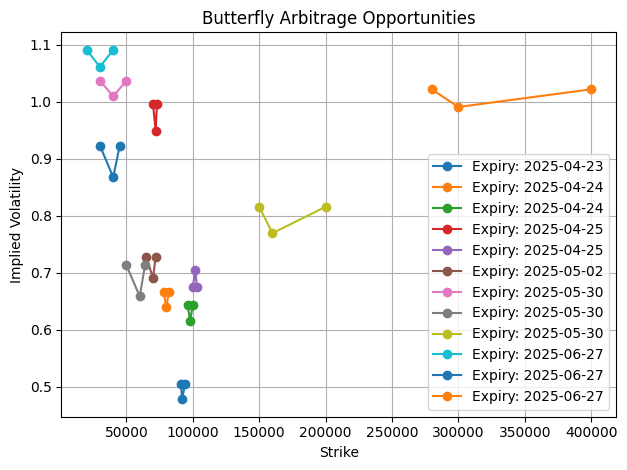

,type,K1,K2,K3,iv_center,iv_side_avg,expiry
0,Butterfly Long,91000.0,92000.0,94000.0,0.478469,0.504872,2025-04-23
1,Butterfly Long,78000.0,80000.0,82000.0,0.640257,0.666681,2025-04-24
2,Butterfly Long,96000.0,98000.0,100000.0,0.615942,0.644239,2025-04-24
3,Butterfly Long,70000.0,72000.0,73000.0,0.949760,0.996201,2025-04-25
4,Butterfly Short,100000.0,102000.0,103000.0,0.705152,0.675707,2025-04-25
5,Butterfly Long,65000.0,70000.0,72000.0,0.691007,0.727982,2025-05-02
6,Butterfly Long,30000.0,40000.0,50000.0,1.009702,1.037206,2025-05-30
7,Butterfly Long,50000.0,60000.0,64000.0,0.658770,0.713445,2025-05-30
8,Butterfly Long,150000.0,160000.0,200000.0,0.769705,0.816026,2025-05-30
9,Butterfly Long,20000.0,30000.0,40000.0,1.061240,1.091328,2025-06-27


In [ ]:
df_butterfly = find_butterfly_arbitrage(df_merged, threshold=0.025)
plot_butterfly_opportunities(df_butterfly)
df_butterfly

In [ ]:
# 캘린더 차익 탐색 함수
def find_calendar_arbitrage(df, threshold=0.03):
    grouped = df.groupby('strike')
    ideas = []

    for strike, group in grouped:
        if len(group) < 2:
            continue
        group = group.sort_values('expiry')
        for i in range(len(group)-1):
            near = group.iloc[i]
            far = group.iloc[i+1]

            iv_near = (near['iv_bid'] + near['iv_ask']) / 2
            iv_far = (far['iv_bid'] + far['iv_ask']) / 2

            if abs(iv_far - iv_near) > threshold:
                ideas.append({
                    "type": "Calendar Spread",
                    "strike": strike,
                    "near_expiry": near['expiry'],
                    "far_expiry": far['expiry'],
                    "iv_near": iv_near,
                    "iv_far": iv_far,
                    "direction": "Long Calendar" if iv_far > iv_near else "Short Calendar"
                })
    return pd.DataFrame(ideas)

def find_calendar_butterfly(df, threshold=0.03):
  ideas = []
  grouped = df.groupby('strike')

  for strike, group in grouped:
      if len(group) < 3:
          continue

      group = group.sort_values('expiry').reset_index(drop=True)

      for i in range(len(group)-2):
          T1 = group.iloc[i]
          T2 = group.iloc[i+1]
          T3 = group.iloc[i+2]

          iv1 = (T1['iv_bid'] + T1['iv_ask']) / 2
          iv2 = (T2['iv_bid'] + T2['iv_ask']) / 2
          iv3 = (T3['iv_bid'] + T3['iv_ask']) / 2

          side_avg = (iv1 + iv3) / 2
          diff = iv2 - side_avg

          if abs(diff) > threshold:
              direction = "Short Calendar Butterfly" if diff > 0 else "Long Calendar Butterfly"
              ideas.append({
                  'type': 'Calendar Butterfly',
                  'direction': direction,
                  'strike': strike,
                  'T1': T1['expiry'],
                  'T2': T2['expiry'],
                  'T3': T3['expiry'],
                  'iv_T1': iv1,
                  'iv_T2': iv2,
                  'iv_T3': iv3,
                  'center_deviation' : diff
              })

  return pd.DataFrame(ideas)

# 캘린더 차익 시각화 함수
def plot_calendar_opportunities(df_calendar):
    plt.figure(figsize=(10, 6))
    for _, row in df_calendar.iterrows():
        x = pd.to_datetime([row['near_expiry'], row['far_expiry']])
        y = [row['iv_near'], row['iv_far']]
        plt.plot(x, y, marker='o', label=f"Strike {row['strike']} ({row['direction']})")

    plt.title("Calendar Arbitrage Across Expiries")
    plt.xlabel("Expiry")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 캘린더 버터플라이 시각화 함수
def plot_calendar_butterfly_opportunities(df_calendar_butterfly):
    plt.figure(figsize=(10, 6))
    for _, row in df_calendar_butterfly.iterrows():
        expiries = pd.to_datetime([row['T1'], row['T2'], row['T3']])
        ivs = [row['iv_T1'], row['iv_T2'], row['iv_T3']]
        plt.plot(expiries, ivs, marker='o', label=f"Strike: {row['strike']} ({row['direction']})")

    plt.title("Calendar Butterfly Opportunities")
    plt.xlabel("Expiry")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# df_cal = find_calendar_arbitrage(df_merged, threshold=0.25)
# plot_calendar_opportunities(df_cal)
# df_cal

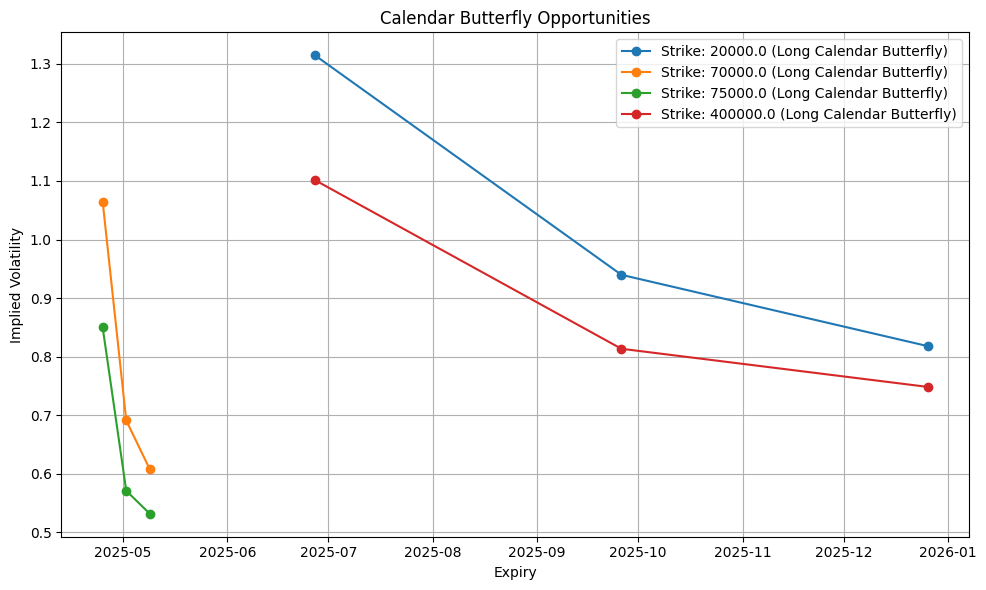

,type,direction,strike,T1,T2,T3,iv_T1,iv_T2,iv_T3,center_deviation
0,Calendar Butterfly,Long Calendar Butterfly,20000.0,2025-06-27,2025-09-26,2025-12-26,1.314657,0.939769,0.817928,-0.126523
1,Calendar Butterfly,Long Calendar Butterfly,70000.0,2025-04-25,2025-05-02,2025-05-09,1.064777,0.691007,0.607577,-0.145170
2,Calendar Butterfly,Long Calendar Butterfly,75000.0,2025-04-25,2025-05-02,2025-05-09,0.849994,0.571010,0.531657,-0.119815
3,Calendar Butterfly,Long Calendar Butterfly,400000.0,2025-06-27,2025-09-26,2025-12-26,1.101506,0.813461,0.748298,-0.111441


In [ ]:
df_calendar_butterfly = find_calendar_butterfly(df_merged, threshold=0.11)
plot_calendar_butterfly_opportunities(df_calendar_butterfly)
df_calendar_butterfly

In [ ]:
from datetime import datetime, timezone
from pysabr import Hagan2002LognormalSABR

def plot_sabr_vol_curve(df, expiry_date_str, beta=0.5):
    """
    지정된 만기일에 대한 SABR 변동성 곡선을 시각화합니다.
    """
    # 해당 만기의 데이터 필터링
    df_expiry = df[df['expiry'] == expiry_date_str].copy()

    # 'iv_mid' 컬럼이 없는 경우 생성
    if 'iv_mid' not in df_expiry.columns:
        df_expiry['iv_mid'] = (df_expiry['iv_bid'] + df_expiry['iv_ask']) / 2

    strikes = df_expiry['strike'].values
    vols = df_expiry['iv_mid'].values

    # 현재 BTC 선물 가격 가져오기
    f = get_btc_futures_last_price()
    if f is None:
        print("현재 BTC 선물 가격을 가져올 수 없습니다.")
        return

    # Deribit 옵션 만기 시간은 08:00 UTC
    try:
        expiry_datetime = datetime.strptime(expiry_date_str, '%Y-%m-%d').replace(hour=8, minute=0, second=0, tzinfo=timezone.utc)
        now = datetime.utcnow().replace(tzinfo=timezone.utc)
        t = (expiry_datetime - now).total_seconds() / (365 * 24 * 60 * 60)
        if t <= 0:
            print("만기일이 이미 지났습니다.")
            return
    except Exception as e:
        print(f"만기 시간 계산 중 오류 발생: {e}")
        return

    # SABR 모델 초기화 및 피팅
    sabr_model = Hagan2002LognormalSABR(f=f, t=t, beta=beta)
    try:
        alpha, rho, volvol = sabr_model.fit(strikes, vols)
    except Exception as e:
        print(f"SABR 모델 피팅 중 오류 발생: {e}")
        return

    # 피팅된 변동성 계산
    fitted_vols = [sabr_model.lognormal_vol(k) for k in strikes]

    # 결과 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, vols, 'o', label='Market IV')
    plt.plot(strikes, fitted_vols, '-', label='SABR Fit')
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.title(f'SABR Volatility Curve for Expiry {expiry_date_str}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_sabr_vol_curve(df_merged, df_merged['expiry'].values[-1])

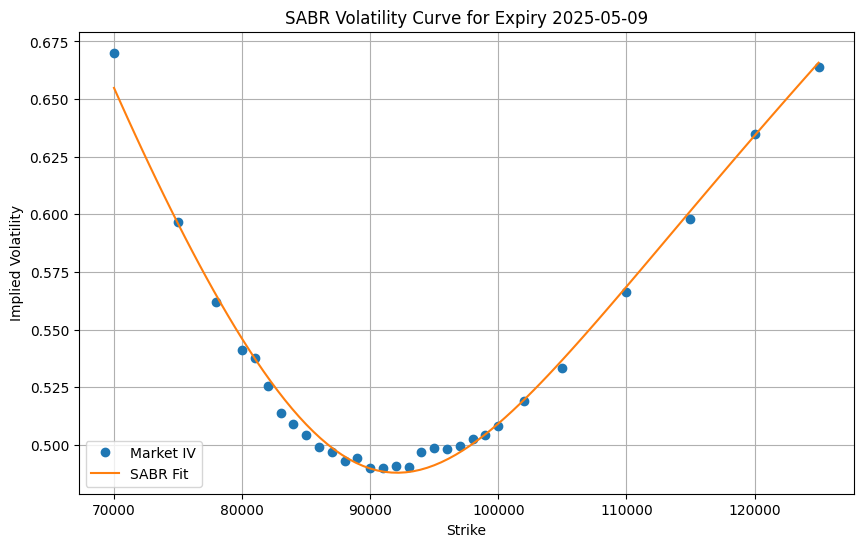

In [ ]:
from pysabr import Hagan2002LognormalSABR
from pysabr import hagan_2002_lognormal_sabr as hagan2002

def plot_sabr_vol_curve(df, expiry_date_str, beta=0.5):
    """
    지정된 만기일에 대한 SABR 변동성 곡선을 시각화합니다.
    """
    # 해당 만기의 데이터 필터링
    df_expiry = df[df['expiry'] == expiry_date_str].copy()

    # 'iv_mid' 컬럼이 없는 경우 생성
    if 'iv_mid' not in df_expiry.columns:
        df_expiry['iv_mid'] = (df_expiry['iv_bid'] + df_expiry['iv_ask']) / 2

    strikes = df_expiry['strike'].values
    vols = df_expiry['iv_mid'].values

    # 현재 BTC 선물 가격 가져오기
    f = get_btc_futures_last_price()
    if f is None:
        print("현재 BTC 선물 가격을 가져올 수 없습니다.")
        return

    # Deribit 옵션 만기 시간은 08:00 UTC
    try:
        expiry_datetime = datetime.strptime(expiry_date_str, '%Y-%m-%d').replace(hour=8, minute=0, second=0, tzinfo=timezone.utc)
        now = datetime.utcnow().replace(tzinfo=timezone.utc)
        t = (expiry_datetime - now).total_seconds() / (365 * 24 * 60 * 60)
        if t <= 0:
            print("만기일이 이미 지났습니다.")
            return
    except Exception as e:
        print(f"만기 시간 계산 중 오류 발생: {e}")
        return

    # SABR 모델 초기화 및 피팅
    sabr_model = Hagan2002LognormalSABR(f=f, t=t, beta=beta)
    try:
        alpha, rho, volvol = sabr_model.fit(strikes, vols)
    except Exception as e:
        print(f"SABR 모델 피팅 중 오류 발생: {e}")
        return

    # 보간을 위한 스트라이크 범위 생성
    k_min, k_max = strikes.min(), strikes.max()
    k_interp = np.linspace(k_min, k_max, 100)

    # 피팅된 변동성 계산
    fitted_vols = [hagan2002.lognormal_vol(k, f, t, alpha, beta, rho, volvol) * 100 for k in k_interp]

    # 결과 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, vols, 'o', label='Market IV')
    plt.plot(k_interp, fitted_vols, '-', label='SABR Fit')
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.title(f'SABR Volatility Curve for Expiry {expiry_date_str}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_sabr_vol_curve(df_merged, df_merged['expiry'].unique()[4])

In [ ]:
call = get_option_instruments()

In [ ]:
call[1]

{'price_index': 'btc_usd',
 'rfq': False,
 'kind': 'option',
 'instrument_name': 'BTC-24APR25-78000-P',
 'maker_commission': 0.0003,
 'taker_commission': 0.0003,
 'instrument_type': 'reversed',
 'expiration_timestamp': 1745481600000,
 'creation_timestamp': 1745222408000,
 'is_active': True,
 'tick_size': 0.0001,
 'contract_size': 1.0,
 'strike': 78000.0,
 'base_currency': 'BTC',
 'instrument_id': 456209,
 'settlement_period': 'day',
 'min_trade_amount': 0.1,
 'option_type': 'put',
 'block_trade_commission': 0.0003,
 'block_trade_min_trade_amount': 25,
 'block_trade_tick_size': 0.0001,
 'settlement_currency': 'BTC',
 'counter_currency': 'USD',
 'quote_currency': 'BTC',
 'tick_size_steps': [{'tick_size': 0.0005, 'above_price': 0.005}]}

In [ ]:
import asyncio
import aiohttp
import pandas as pd

# 전역 캐시: 불변 데이터(종목 리스트 등)를 저장하여 재사용
deribit_instruments_cache = None  # Deribit 옵션 리스트 캐시
binance_symbols_cache = None      # Binance 옵션 심볼 리스트 캐시

async def fetch_deribit_data(session):
    """Deribit BTC 옵션 데이터 조회 (옵션 리스트 + 각 옵션 시세)"""
    global deribit_instruments_cache
    # 1) Deribit 옵션 목록 (캐시 사용)
    if deribit_instruments_cache is None:
        inst_url = "https://www.deribit.com/api/v2/public/get_instruments"
        params = {"currency": "BTC", "kind": "option", "expired": "false"}
        async with session.get(inst_url, params=params) as resp:
            data = await resp.json()
            if "result" in data:
                # 결과를 딕셔너리에 저장: instrument_name -> instrument 정보
                deribit_instruments_cache = {
                    inst["instrument_name"]: inst for inst in data["result"]
                }
            else:
                deribit_instruments_cache = {}
    instruments = deribit_instruments_cache

    # 2) Deribit 옵션 시세 데이터 (모든 옵션의 요약 정보)
    summary_url = "https://www.deribit.com/api/v2/public/get_book_summary_by_currency"
    params = {"currency": "BTC", "kind": "option"}
    async with session.get(summary_url, params=params) as resp:
        data = await resp.json()
        summaries = data.get("result", [])
    # 3) Deribit 지수 가격 (BTC 지수 가격 - 풋콜 패리티 계산에 사용)
    index_url = "https://www.deribit.com/api/v2/public/get_index_price"
    params = {"index_name": "btc_usd"}  # BTC-USD 지수
    async with session.get(index_url, params=params) as resp:
        data = await resp.json()
        # get_index_price 응답: {"result": {"index_price": ..., "estimated_delivery_price": ...}}
        deribit_index_price = data.get("result", {}).get("index_price", None)

    # 4) 데이터 병합: 옵션 리스트 + 시세 요약 병합하여 DataFrame 생성
    records = []
    for summ in summaries:
        name = summ.get("instrument_name")
        if not name or name not in instruments:
            continue
        inst = instruments[name]
        # 옵션 기본 정보
        kind = inst.get("option_type")   # "call" 또는 "put"
        strike = inst.get("strike")
        exp_timestamp = inst.get("expiration_timestamp")
        # 만기 시간을 datetime.date로 변환 (두 거래소 데이터 비교에 사용)
        exp_date = pd.to_datetime(exp_timestamp, unit='ms').date() if exp_timestamp else None
        # 옵션 현재 가격 결정: 최우선 매도/매수 평균이나 없는 경우 last/mark 사용
        bid = summ.get("bid_price")
        ask = summ.get("ask_price")
        last = summ.get("last")
        mark = summ.get("mark_price")
        if bid is not None and ask is not None:
            price = (bid + ask) / 2.0
        elif last is not None:
            price = last
        else:
            price = mark  # 호가가 없으면 이론가(마크 프라이스) 사용
        records.append({
            "exchange": "Deribit",
            "type": kind.lower() if kind else None,  # "call"/"put"
            "strike": strike,
            "expiry": exp_date,
            "price": price
        })
    df_deribit = pd.DataFrame(records)
    return df_deribit, deribit_index_price

async def fetch_binance_data(session):
    """Binance BTC 옵션 데이터 조회 (옵션 심볼 리스트 + 각 옵션 시세)"""
    global binance_symbols_cache
    # 1) Binance 옵션 심볼 목록 (캐시 사용)
    if binance_symbols_cache is None:
        info_url = "https://eapi.binance.com/eapi/v1/exchangeInfo"
        async with session.get(info_url) as resp:
            data = await resp.json()
            symbols_info = data.get("optionSymbols", [])
            # BTC 기초자산의 옵션만 필터링 (symbol명이 'BTC-'로 시작)
            # binance_symbols_cache = [s for s in symbols_info if s.get("symbol", "").startswith("BTC-")]
            binance_symbols_cache = [s for s in symbols_info if s.get("underlying") == "BTCUSDT"]
    symbols = binance_symbols_cache

    # 2) Binance BTC 현물 지수 가격 조회 (BTCUSDT 지수 가격)
    idx_url = "https://eapi.binance.com/eapi/v1/index"
    params = {"underlying": "BTCUSDT"}  # BTC 기초 자산에 대한 인덱스 가격 (BTCUSDT)
    async with session.get(idx_url, params=params) as resp:
        data = await resp.json()
        # indexPrice 필드에 현물 지수 가격 제공
        binance_index_price = data.get("indexPrice", None)

    # 3) 각 옵션 심볼의 마크 가격 동시 조회 (비동기 병렬)
    records = []
    # 심볼별 API 요청 작업 생성
    tasks = []
    for sym in symbols:
        symbol_name = sym.get("symbol")
        if not symbol_name:
            continue
        # /eapi/v1/mark 엔드포인트로 해당 옵션의 마크가격 및 그릭스 조회
        url = "https://eapi.binance.com/eapi/v1/mark"
        params = {"symbol": symbol_name}
        tasks.append(session.get(url, params=params))
    # 병렬 요청 실행
    responses = await asyncio.gather(*tasks)
    # 4) 응답 파싱 및 DataFrame 생성
    for resp, sym in zip(responses, symbols):
        data = await resp.json()
        # symbol, markPrice 등이 응답에 포함됨
        symbol_name = data.get("symbol")
        mark_price = data.get("markPrice")
        if not symbol_name or mark_price is None:
            continue
        # Binance 심볼 상세 정보에서 행사가, 만기, 옵션 종류 추출
        strike_str = sym.get("strikePrice")
        expiry_ts = sym.get("expiryDate")  # 만기 시간 (ms)
        opt_side = sym.get("side")         # "CALL" 또는 "PUT"
        # 필요한 값 변환
        strike = float(strike_str) if strike_str is not None else None
        exp_date = pd.to_datetime(expiry_ts, unit='ms').date() if expiry_ts else None
        opt_type = opt_side.lower() if opt_side else None  # "call"/"put"
        records.append({
            "exchange": "Binance",
            "type": opt_type,
            "strike": strike,
            "expiry": exp_date,
            "price": float(mark_price)
        })
    df_binance = pd.DataFrame(records)
    return df_binance, binance_index_price

def detect_convexity_arbitrage(df):
    """Convexity (Butterfly) Arbitrage 탐지: 동일 만기 내 옵션 가격의 볼록성 위반 검사"""
    arbitrages = []
    # 옵션 종류별로 각각 검사 (콜과 풋을 분리하여 convexity 조건 확인)
    for opt_type, group in df.groupby("type"):
        if opt_type not in ["call", "put"]:
            continue
        # 만기별 그룹화
        for expiry, grp in group.groupby("expiry"):
            prices = grp.sort_values("strike")
            strikes = prices["strike"].values
            values = prices["price"].values
            n = len(values)
            # 행사가 2개 이하는 convexity 검사 불가 (skip)
            if n < 2:
                continue
            # 우선 인접한 두 행사가 간의 **단조성** 확인
            # 콜: 행사가 높아질 때 가격이 내려가는지, 풋: 행사가 높아질 때 가격이 올라가는지 체크
            for i in range(n - 1):
                K1, K2 = strikes[i], strikes[i+1]
                P1, P2 = values[i], values[i+1]
                if opt_type == "call" and P1 < P2:
                    # 콜 옵션 가격이 행사가 낮은 쪽이 더 낮다면 (단조 감소 위반)
                    arbitrages.append({
                        "Type": "Convexity", "Exchange": prices.iloc[i]["exchange"],
                        "OptionType": opt_type.capitalize(),
                        "Expiry": expiry,
                        "Strike": K1, "Strike2": K2, "Strike3": None,
                        "Price": P1, "Price2": P2, "Price3": None,
                        "Difference": P2 - P1  # 가격차 (위반 정도)
                    })
                if opt_type == "put" and P1 > P2:
                    # 풋 옵션 가격이 행사가 낮은 쪽이 더 높다면 (단조 증가 위반)
                    arbitrages.append({
                        "Type": "Convexity", "Exchange": prices.iloc[i]["exchange"],
                        "OptionType": opt_type.capitalize(),
                        "Expiry": expiry,
                        "Strike": K1, "Strike2": K2, "Strike3": None,
                        "Price": P1, "Price2": P2, "Price3": None,
                        "Difference": P1 - P2
                    })
            # 3개 이상 행사가일 경우 볼록성 조건 검사
            if n >= 3:
                for j in range(1, n-1):
                    K1, K2, K3 = strikes[j-1], strikes[j], strikes[j+1]
                    P1, P2, P3 = values[j-1], values[j], values[j+1]
                    # 선형보간 가중치 lambda 계산
                    lam = (K3 - K2) / (K3 - K1) if K3 != K1 else 0.5
                    linear_price = lam * P1 + (1 - lam) * P3  # K2에서의 선형 보간 가격
                    # 콜/풋 공통: 중간 가격이 선형보간보다 높으면 볼록성 위반 (차익거래 가능)
                    if P2 > linear_price:
                        arbitrages.append({
                            "Type": "Convexity", "Exchange": prices.iloc[j]["exchange"],
                            "OptionType": opt_type.capitalize(),
                            "Expiry": expiry,
                            "Strike": K1, "Strike2": K2, "Strike3": K3,
                            "Price": P1, "Price2": P2, "Price3": P3,
                            "Difference": P2 - linear_price  # 선형보간값 대비 초과
                        })
    return arbitrages

def detect_term_structure_arbitrage(df):
    """Term Structure (Calendar) Arbitrage 탐지: 동일 행사가 옵션의 만기별 가격 역전 검사"""
    arbitrages = []
    # 콜과 풋 별도로 검사
    for opt_type, group in df.groupby("type"):
        if opt_type not in ["call", "put"]:
            continue
        # 행사가별 그룹화
        for strike, grp in group.groupby("strike"):
            # 만기순으로 정렬
            prices = grp.sort_values("expiry")
            expiries = prices["expiry"].values
            values = prices["price"].values
            # 인접 만기쌍 비교 (더 짧은 만기의 가격이 더 긴 만기보다 높으면 차익거래)
            for i in range(len(values) - 1):
                price_short = values[i]
                price_long = values[i+1]
                exp_short = expiries[i]
                exp_long = expiries[i+1]
                if price_short > price_long:
                    arbitrages.append({
                        "Type": "Term Structure", "Exchange": prices.iloc[i]["exchange"],
                        "OptionType": opt_type.capitalize(),
                        "Strike": strike,
                        "Expiry": exp_short, "Expiry2": exp_long,
                        "Price": price_short, "Price2": price_long,
                        "Difference": price_short - price_long
                    })
    return arbitrages

def detect_put_call_parity_arbitrage(df, underlying_price):
    """Put-Call Parity Arbitrage 탐지: 동일 만기/행사가 콜-풋 가격관계 위반 검사"""
    arbitrages = []
    # 동일 만기와 행사가로 그룹화
    for (expiry, strike), grp in df.groupby(["expiry", "strike"]):
        # 콜과 풋이 모두 존재해야 함
        types = set(grp["type"])
        if not ("call" in types and "put" in types):
            continue
        # 콜/풋 가격 추출
        call_price = grp[grp["type"] == "call"]["price"].iloc[0]
        put_price = grp[grp["type"] == "put"]["price"].iloc[0]
        # 풋-콜 패리티: C - P ?= S - K  (이자율 및 비용 무시, 현물가격 S 사용)
        parity_diff = call_price - put_price - (underlying_price - strike)
        # 차이가 0이 아니면 차익 가능 (약간의 오차 허용을 위해 작은 threshold 적용)
        if abs(parity_diff) > 1e-2:
            arbitrages.append({
                "Type": "Put-Call Parity", "Exchange": grp.iloc[0]["exchange"],
                "Strike": strike, "Expiry": expiry,
                "Price": call_price, "Price2": put_price,
                "Difference": parity_diff
            })
    return arbitrages

def detect_inter_exchange_arbitrage(df_deribit, df_binance):
    """두 거래소 간 Arbitrage 탐지: 동일 행사가/만기/종류의 옵션 가격 차이 검사"""
    arbitrages = []
    if df_deribit.empty or df_binance.empty:
        return arbitrages
    # 행사가, 만기 날짜(date), 옵션종류 기준으로 내부 조인하여 매칭되는 옵션 찾기
    df1 = df_deribit.copy()
    df2 = df_binance.copy()
    # 만기는 date 형식으로 맞춰서 비교 (시간 차이 보정)
    df1["expiry_date"] = df1["expiry"]
    df2["expiry_date"] = df2["expiry"]
    df1["OptionType"] = df1["type"].str.capitalize()
    df2["OptionType"] = df2["type"].str.capitalize()
    # 중복 제거 (동일 키 여러 행 존재 방지 - 이론상 불필요하지만 안전차원)
    df1 = df1.drop_duplicates(subset=["strike", "expiry_date", "OptionType"])
    df2 = df2.drop_duplicates(subset=["strike", "expiry_date", "OptionType"])
    # 내부 조인 (same strike, same expiry date, same type)
    merged = pd.merge(df1, df2, on=["strike", "expiry_date", "OptionType"], suffixes=("_deribit", "_binance"))
    for _, row in merged.iterrows():
        price_deribit = row["price_deribit"]
        price_binance = row["price_binance"]
        diff = price_deribit - price_binance
        # 두 가격 차이가 있으면 (절대값 0.01 이상) 차익거래 가능으로 기록
        if abs(diff) > 1e-2:
            arbitrages.append({
                "Type": "Inter-Exchange", "Exchange": "Deribit-Binance",
                "OptionType": row["OptionType"],
                "Strike": row["strike"], "Expiry": row["expiry_date"],
                "Price": price_deribit, "Price2": price_binance,
                "Difference": diff
            })
    return arbitrages

async def main():
    # aiohttp 세션 생성
    async with aiohttp.ClientSession() as session:
        # Deribit 및 Binance 데이터 병렬 수집
        deribit_task = asyncio.create_task(fetch_deribit_data(session))
        binance_task = asyncio.create_task(fetch_binance_data(session))
        df_deribit, deribit_index = await deribit_task
        df_binance, binance_index = await binance_task

        # 각 거래소 내 Arbitrage 탐지
        arbs = []
        arbs += detect_convexity_arbitrage(df_deribit)
        arbs += detect_term_structure_arbitrage(df_deribit)
        arbs += detect_put_call_parity_arbitrage(df_deribit, underlying_price=deribit_index if deribit_index else 0.0)
        arbs += detect_convexity_arbitrage(df_binance)
        arbs += detect_term_structure_arbitrage(df_binance)
        arbs += detect_put_call_parity_arbitrage(df_binance, underlying_price=binance_index if binance_index else 0.0)
        # 거래소 간 Arbitrage 탐지
        arbs += detect_inter_exchange_arbitrage(df_deribit, df_binance)

        # 결과를 하나의 DataFrame으로 통합
        result_df = pd.DataFrame(arbs)
        # Type별로 정렬 (보기 편하게)
        if not result_df.empty:
            result_df = result_df.sort_values(by=["Type", "Exchange"])
        # 출력: 통합 데이터프레임
        print("발견된 차익거래 기회:")
        print(result_df.to_string(index=False))  # 표 형태 출력

# 비동기 실행
asyncio.run(main())


hehre
{'code': 0, 'msg': "Service unavailable from a restricted location according to 'b. Eligibility' in https://www.binance.com/en/terms. Please contact customer service if you believe you received this message in error."}
[]
[]
Empty DataFrame
Columns: []
Index: []


KeyError: 'type'

In [ ]:
import requests
import asyncio
import aiohttp
import pandas as pd
import time
from datetime import datetime
import nest_asyncio

nest_asyncio.apply()
pd.set_option('display.width', 0)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Deribit 옵션 리스트 가져오기
def get_option_instruments(currency="BTC", kind="option", expired=False):
    url = "https://www.deribit.com/api/v2/public/get_instruments"
    params = {"currency": currency, "kind": kind, "expired": str(expired).lower()}
    response = requests.get(url, params=params)
    data = response.json()
    return data.get("result", []) if 'error' not in data else []

def get_deribit_options(option_type='call'):
    return [x for x in get_option_instruments() if x["option_type"] == option_type]

# BTC-PERPETUAL Bid/Ask 가격 가져오기
def get_perpetual_bid_ask():
    url = "https://www.deribit.com/api/v2/public/get_order_book"
    params = {"instrument_name": "BTC-PERPETUAL"}
    response = requests.get(url, params=params)
    data = response.json()
    result = data.get("result", {})
    return result["best_bid_price"], result["best_ask_price"]

def get_btc_usd_price():
    url = "https://www.deribit.com/api/v2/public/get_index_price"
    params = {"index_name": "btc_usd"}
    response = requests.get(url, params=params)
    data = response.json()
    return data["result"]["index_price"]

# 옵션 주문 데이터 가져오기
async def fetch_order_book(session, option):
    url = "https://www.deribit.com/api/v2/public/get_order_book"
    params = {"instrument_name": option["instrument_name"]}
    try:
        async with session.get(url, params=params, timeout=5) as resp:
            data = await resp.json()
            ob = data.get("result", {})
            if ob.get("best_ask_price") and ob.get("best_bid_price"):
                return {
                    "strike": option["strike"],
                    "instrument": option["instrument_name"],
                    "bid": ob["best_bid_price"],
                    "ask": ob["best_ask_price"],
                    "expiration_timestamp": option["expiration_timestamp"],
                    "option_type": option["option_type"]
                }
    except:
        return None

async def fetch_order_books_for_expiry(session, option_list):
    tasks = [fetch_order_book(session, opt) for opt in option_list]
    results = await asyncio.gather(*tasks)
    return [r for r in results if r]

# Convexity Arbitrage 탐지
def detect_convexity_arbitrage(df, option_type):
    df_sorted = df.sort_values("strike")
    violations = []

    for i in range(1, len(df_sorted) - 1):
        K1, K2, K3 = df_sorted.iloc[i-1], df_sorted.iloc[i], df_sorted.iloc[i+1]
        if any([K1["ask"] in [None, 0], K2["bid"] in [None, 0], K3["ask"] in [None, 0]]):
            continue

        fee_total = 0.0005 * (K1["ask"] + 2*K2["bid"] + K3["ask"])

        w_lambda = (K3["strike"] - K2["strike"]) / (K3["strike"] - K1["strike"])
        avg_outer_ask = w_lambda * K1["ask"] + (1 - w_lambda) * K3["ask"]
        net_profit = K2["bid"] - avg_outer_ask - fee_total

        if net_profit > 0:
            violations.append({
                "type": "Convexity",
                "option_type": option_type,
                "K1": K1["strike"],
                "K2": K2["strike"],
                "K3": K3["strike"],
                "net_profit_after_fee": round(net_profit, 8),
                "expiry": datetime.utcfromtimestamp(K2["expiration_timestamp"]/1000).strftime('%Y-%m-%d')
            })
    return pd.DataFrame(violations)

# Term Structure Arbitrage 탐지
def detect_term_structure_arbitrage(all_order_books, expiries, option_type):
    df = pd.concat(
        [pd.DataFrame(group).assign(expiry=datetime.utcfromtimestamp(exp/1000).strftime('%Y-%m-%d')) for group, exp in zip(all_order_books, expiries)],
        ignore_index=True
    )
    if df.empty:
        return pd.DataFrame()

    violations = []
    grouped = df.groupby("strike")
    for strike, group in grouped:
        group_sorted = group.sort_values("expiry")
        for i in range(len(group_sorted) - 1):
            short = group_sorted.iloc[i]
            long = group_sorted.iloc[i+1]
            if short.get("bid") and long.get("ask"):
                fee_total = 0.0005 * (short["bid"] + long["ask"])
                net_profit = short["bid"] - long["ask"] - fee_total
                if net_profit > -10:
                    violations.append({
                        "type": "TermStructure",
                        "option_type": option_type,
                        "strike": strike,
                        "short_expiry": short["expiry"],
                        "long_expiry": long["expiry"],
                        "net_profit_after_fee": round(net_profit, 8)
                    })
    return pd.DataFrame(violations)

def detect_put_call_parity_arbitrage(call_data, put_data, perp_bid, perp_ask, tolerance=0):
    violations = []
    merged = pd.merge(call_data, put_data, on=['strike', 'expiration_timestamp'], suffixes=('_call', '_put'))

    btc_usd_price = get_btc_usd_price()

    for _, row in merged.iterrows():
        strike = row['strike']
        expiry = datetime.utcfromtimestamp(row['expiration_timestamp']/1000).strftime('%Y-%m-%d')
        call_ask = row['ask_call'] * btc_usd_price
        call_bid = row['bid_call'] * btc_usd_price
        put_ask = row['ask_put'] * btc_usd_price
        put_bid = row['bid_put'] * btc_usd_price

        if pd.isnull(call_ask) or pd.isnull(call_bid) or pd.isnull(put_ask) or pd.isnull(put_bid):
            continue

        # 수수료 계산
        fee_case1 = (0.0005 * call_ask) + (0.0005 * put_bid) + (0.0005 * perp_bid)
        fee_case2 = (0.0005 * call_bid) + (0.0005 * put_ask) + (0.0005 * perp_ask)

        # C − P = S − K

        # max(C - P) = C_ask - P_bid, min(S - K) = S_bid - K
        # (1) max(lhs) < min (rhs): 왼쪽 사고 오른쪽 팔기
        lhs_1 = call_ask - put_bid
        rhs_1 = perp_bid - strike
        diff_1 = rhs_1 - lhs_1 - fee_case1

        # min(C - P) = C_bid - P_ask, max(S - K) = S_ask - K
        # (2) min(lhs) > max (rhs): 왼쪽 팔고 오른쪽 사기
        lhs_2 = call_bid - put_ask
        rhs_2 = perp_ask - strike
        diff_2 = lhs_2 - rhs_2 - fee_case2

        if diff_1 > tolerance * strike:
            violations.append({
                'type': 'Put-Call Parity (풋 bid - 콜 ask, perp bid)',
                'strike': strike,
                'expiry': expiry,
                'put_bid': put_bid,
                'call_ask': call_ask,
                'perp_bid': perp_bid,
                'total_fee': round(fee_case1, 8),
                'net_difference_after_fee': round(diff_1, 8)
            })

        if diff_2 > tolerance * strike:
            violations.append({
                'type': 'Put-Call Parity (풋 ask - 콜 bid, perp ask)',
                'strike': strike,
                'expiry': expiry,
                'put_ask': put_ask,
                'call_bid': call_bid,
                'perp_ask': perp_ask,
                'total_fee': round(fee_case2, 8),
                'net_difference_after_fee': round(diff_2, 8)
            })

    return pd.DataFrame(violations)

# 전체 분석 함수
async def analyze_recent_expiries_async(call_options, put_options, n_expiry=5):
    if not call_options or not put_options:
        return pd.DataFrame()

    expiries = sorted(set(x["expiration_timestamp"] for x in call_options))[:n_expiry]
    expiry_groups_call = [[x for x in call_options if x["expiration_timestamp"] == expiry] for expiry in expiries]
    expiry_groups_put = [[x for x in put_options if x["expiration_timestamp"] == expiry] for expiry in expiries]

    connector = aiohttp.TCPConnector(limit=100)
    timeout = aiohttp.ClientTimeout(total=10)

    all_violations = []
    async with aiohttp.ClientSession(connector=connector, timeout=timeout) as session:
        fetch_call = [fetch_order_books_for_expiry(session, group) for group in expiry_groups_call]
        fetch_put = [fetch_order_books_for_expiry(session, group) for group in expiry_groups_put]
        fetch_all = [asyncio.gather(*fetch_call), asyncio.gather(*fetch_put)]

        call_results, put_results = await asyncio.gather(*fetch_all)

        perp_bid, perp_ask = get_perpetual_bid_ask()

        for call_group, put_group, expiry in zip(call_results, put_results, expiries):
            call_df = pd.DataFrame(call_group)
            put_df = pd.DataFrame(put_group)

            if call_df.empty or put_df.empty:
                continue

            convex_call = detect_convexity_arbitrage(call_df, 'call')
            convex_put = detect_convexity_arbitrage(put_df, 'put')

            term_call = detect_term_structure_arbitrage([call_group], [expiry], 'call')
            term_put = detect_term_structure_arbitrage([put_group], [expiry], 'put')

            putcall = detect_put_call_parity_arbitrage(call_df, put_df, perp_bid, perp_ask)

            all_violations.extend([convex_call, convex_put, term_call, term_put, putcall])

    return pd.concat(all_violations, ignore_index=True) if all_violations else pd.DataFrame()

# 실행 루프
def run_continuous_check(interval_sec=300):
    while True:
        print(f"\n⏱️ 실행 시간: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")

        call_options = get_deribit_options('call')
        put_options = get_deribit_options('put')

        violations = asyncio.get_event_loop().run_until_complete(
            analyze_recent_expiries_async(call_options, put_options, n_expiry=15)
        )

        if violations.empty:
            print("✅ 현재 차익기회 없음")
        else:
            print("\n⚡ 차익기회 포착:")
            print(violations)

        time.sleep(interval_sec)

# ▶️ 실행
run_continuous_check(interval_sec=0)


⏱️ 실행 시간: 2025-04-28 08:53:22 UTC
✅ 현재 차익기회 없음

⏱️ 실행 시간: 2025-04-28 08:53:29 UTC
✅ 현재 차익기회 없음

⏱️ 실행 시간: 2025-04-28 08:53:35 UTC
✅ 현재 차익기회 없음

⏱️ 실행 시간: 2025-04-28 08:53:40 UTC
✅ 현재 차익기회 없음

⏱️ 실행 시간: 2025-04-28 08:53:44 UTC
✅ 현재 차익기회 없음

⏱️ 실행 시간: 2025-04-28 08:53:49 UTC
✅ 현재 차익기회 없음

⏱️ 실행 시간: 2025-04-28 08:53:54 UTC
✅ 현재 차익기회 없음

⏱️ 실행 시간: 2025-04-28 08:53:59 UTC
✅ 현재 차익기회 없음

⏱️ 실행 시간: 2025-04-28 08:54:03 UTC
✅ 현재 차익기회 없음

⏱️ 실행 시간: 2025-04-28 08:54:08 UTC
✅ 현재 차익기회 없음

⏱️ 실행 시간: 2025-04-28 08:54:13 UTC


KeyboardInterrupt: 

선-선차익

In [ ]:
import time
import asyncio
import aiohttp
from datetime import datetime

# Updated trading fee rates
BINANCE_MAKER_FEE_RATE = 0.0002  # 0.02%
BINANCE_TAKER_FEE_RATE = 0.0005  # 0.05%
DERIBIT_MAKER_FEE_RATE = 0.0000  # 0.00%
DERIBIT_TAKER_FEE_RATE = 0.0005  # 0.05%

# Funding interval and time constants
FUNDING_INTERVAL_HOURS = 8
SECONDS_IN_HOUR = 3600

# Binance: Fetch price and funding rate
async def get_binance_data(session):
    try:
        # Price information
        price_url = "https://testnet.binancefuture.com/fapi/v1/ticker/price?symbol=BTCUSDT"
        async with session.get(price_url) as resp:
            price_data = await resp.json()
            price = float(price_data['price'])

        # Funding rate information
        funding_url = "https://testnet.binancefuture.com/fapi/v1/premiumIndex?symbol=BTCUSDT"
        async with session.get(funding_url) as resp:
            funding_data = await resp.json()
            funding_rate = float(funding_data['lastFundingRate'])

        return {'price': price, 'funding_rate': funding_rate}
    except Exception as e:
        print(f"Error fetching Binance data: {e}")
        return None

async def get_deribit_data(session):
    try:
        # Price information
        price_url = "https://www.deribit.com/api/v2/public/ticker"
        price_params = {"instrument_name": "BTC-PERPETUAL"}
        async with session.get(price_url, params=price_params) as resp:
            price_data = await resp.json()
            price = float(price_data['result']['last_price'])
            best_ask_price = float(price_data['result']['best_ask_price'])
            best_bid_price = float(price_data['result']['best_bid_price'])


        # Funding rate information
        funding_url = "https://www.deribit.com/api/v2/public/get_funding_rate_value"
        end_timestamp = int(time.time() * 1000)  # Current time in milliseconds
        start_timestamp = end_timestamp - FUNDING_INTERVAL_HOURS * SECONDS_IN_HOUR * 1000  # 8 hours ago
        funding_params = {
            "instrument_name": "BTC-PERPETUAL",
            "start_timestamp": start_timestamp,
            "end_timestamp": end_timestamp
        }
        async with session.get(funding_url, params=funding_params) as resp:
            funding_data = await resp.json()
            funding_rate = float(funding_data['result'])

        return {'price':price, 'ask': best_ask_price, 'bid':best_bid_price, 'funding_rate': funding_rate}
    except Exception as e:
        print(f"Error fetching Deribit data: {e}")
        return None

# 전략별 순이익 계산 및 평가
def evaluate_arbitrage(binance_data, deribit_data):
    if not binance_data or not deribit_data:
        print("데이터 부족")
        return

    b_price = binance_data['price']
    d_price = deribit_data['price']
    d_ask = deribit_data['ask']
    d_bid = deribit_data['bid']
    b_funding = binance_data['funding_rate']
    d_funding = deribit_data['funding_rate']

    # Assuming both entry and exit are taker orders
    fee_total = BINANCE_TAKER_FEE_RATE * b_price + DERIBIT_TAKER_FEE_RATE * d_price

    # 전략 1: Binance 롱 (펀딩 지불), Deribit 숏 (펀딩 수령)
    profit1 = (d_bid - b_price) - fee_total # - (b_funding * b_price) + (d_funding * d_price)

    # 전략 2: Binance 숏 (펀딩 수령), Deribit 롱 (펀딩 지불)
    profit2 = (b_price - d_ask) - fee_total # - (d_funding * d_price) + (b_funding * b_price)

    print(f"\n🕒 {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")
    print(f"Binance: {b_price:.2f} (펀딩: {b_funding:.6f}), Deribit: {d_ask:.2f} / {d_price:.2f} / {d_bid:.2f} (펀딩: {d_funding:.6f})")
    print(f"총 수수료: {fee_total:.6f}")
    print(f"전략1 (Binance 롱 / Deribit 숏): {profit1:.4f} USDT")
    print(f"전략2 (Binance 숏 / Deribit 롱): {profit2:.4f} USDT")

    if profit1 > profit2 and profit1 > 0:
        print("✅ 전략 추천: Binance 롱 / Deribit 숏")
    elif profit2 > profit1 and profit2 > 0:
        print("✅ 전략 추천: Binance 숏 / Deribit 롱")
    else:
        print("❌ 수익 기회 없음")

# Main loop
async def main_loop():
    async with aiohttp.ClientSession() as session:
        while True:
            binance_data = await get_binance_data(session)
            deribit_data = await get_deribit_data(session)
            evaluate_arbitrage(binance_data, deribit_data)
            await asyncio.sleep(5)

# Run the main loop
asyncio.run(main_loop())



🕒 2025-04-23 12:10:12 UTC
Binance: 93572.00 (펀딩: 0.000055), Deribit: 93679.00 / 93679.00 / 93678.50 (펀딩: 0.000003)
총 수수료: 93.625500
전략1 (Binance 롱 / Deribit 숏): 12.8745 USDT
전략2 (Binance 숏 / Deribit 롱): -200.6255 USDT
✅ 전략 추천: Binance 롱 / Deribit 숏

🕒 2025-04-23 12:10:18 UTC
Binance: 93570.80 (펀딩: 0.000055), Deribit: 93690.00 / 93690.00 / 93689.50 (펀딩: 0.000003)
총 수수료: 93.630400
전략1 (Binance 롱 / Deribit 숏): 25.0696 USDT
전략2 (Binance 숏 / Deribit 롱): -212.8304 USDT
✅ 전략 추천: Binance 롱 / Deribit 숏

🕒 2025-04-23 12:10:24 UTC
Binance: 93558.40 (펀딩: 0.000055), Deribit: 93700.50 / 93700.50 / 93700.00 (펀딩: 0.000003)
총 수수료: 93.629450
전략1 (Binance 롱 / Deribit 숏): 47.9706 USDT
전략2 (Binance 숏 / Deribit 롱): -235.7295 USDT
✅ 전략 추천: Binance 롱 / Deribit 숏

🕒 2025-04-23 12:10:30 UTC
Binance: 93570.80 (펀딩: 0.000055), Deribit: 93702.50 / 93701.50 / 93702.00 (펀딩: 0.000003)
총 수수료: 93.636150
전략1 (Binance 롱 / Deribit 숏): 37.5638 USDT
전략2 (Binance 숏 / Deribit 롱): -225.3361 USDT
✅ 전략 추천: Binance 롱 / Deribit 숏


KeyboardInterrupt: 

In [ ]:
get_iv_for_option(inst_name)

{'timestamp': 1745227517223, 'state': 'open', 'stats': {'high': None, 'low': None, 'price_change': None, 'volume': 0.0, 'volume_usd': 0.0}, 'greeks': {'delta': 0.99991, 'gamma': 0.0, 'vega': 0.01606, 'theta': -0.5964, 'rho': 1.95908}, 'change_id': 97992839864, 'index_price': 87448.23, 'instrument_name': 'BTC-22APR25-76000-C', 'bids': [[0.0995, 10.3]], 'asks': [[0.1605, 10.3]], 'last_price': None, 'settlement_price': 0.13092624, 'min_price': 0.0995, 'max_price': 0.1605, 'open_interest': 0.0, 'mark_price': 0.131, 'best_ask_price': 0.1605, 'best_bid_price': 0.0995, 'interest_rate': 0.0, 'mark_iv': 74.25, 'bid_iv': 0.0, 'ask_iv': 414.29, 'underlying_price': 87456.8408, 'underlying_index': 'SYN.BTC-22APR25', 'estimated_delivery_price': 87448.23, 'best_ask_amount': 10.3, 'best_bid_amount': 10.3}
